# FFF Workshop

## B2: Sampling and scoring selections of catalogue compounds

### Outline

- Quoting compounds from Enamine manually
- Retrosynthesis with syndirella
- Exploring reactions and routes
- Recipes
- Loading Quotes from a reference Database
- Generating a quoted Recipe

In [1]:
%load_ext autoreload
%autoreload 2
import hippo
animal = hippo.HIPPO(
    "A71EV2A_demo",
    "../data/A71EV2A.sqlite",
)

 Creating HIPPO animal

name = A71EV2A_demo

db_path = ../data/A71EV2A.sqlite

DEBUG: hippo.Database.__init__()

DEBUG: Database.path = ../data/A71EV2A.sqlite

DEBUG: hippo.Database.connect()

DEBUG: sqlite3.version='2.6.0'

 Success  Database connected @ ../data/A71EV2A.sqlite!

 Success  Initialised animal HIPPO("A71EV2A_demo")!

## Simulating a real-world selection problem

We left the last notebook with a synthesis recipe describing how to get to 31 of our A71EV2A OpenBind scaffold compounds, which required almost €7k of reactants:

In [27]:
chem_recipe = hippo.Recipe.from_json(animal.db, "c1_scaffolds_in_stock.json")

 DISK  Reading c1_scaffolds_in_stock.json...

Recipe was generated at: 2025-11-07 17:04:46.101390

reactants = {Ingredient × 56}

intermediates = {Ingredient × 1}

products = {Ingredient × 31}

reactions = {R × 32}

compounds = {Ingredient × 0}

We also saw that tha average cost of our catalogue-available scaffold compounds was around €120, so it seems we might be able to come up with a more cost-effective plan using catalogue compounds instead of relying on in-house synthesis. Especially since some compounds are much cheaper still:

In [4]:
quoted_scaffolds = animal.compounds(tag="openbind_a71ev2a_c1_scaffolds_quoted")
quoted_scaffolds[0].get_quotes(df=True)

,id,smiles,supplier,catalogue,entry,amount,price,purity,lead_time,date,type
0,17851,CC(C1=NC=2C=CC=CC2O1)N3CCN(CC3)C4CCS(=O)(=O)C4,Enamine,HTS,Z1615901126,5.0,€27.20 EUR,0.9,10,2025-11-09,None


What might not be totally obvious though is how we might quantify the quality of our selections. If we just wanted the most compounds for the given budget we could just sort the scaffolds by price and choose the top X until the budget is exceeded. First get an IngredientSet with 1mg amounts of every quoted scaffolds:

In [5]:
quoted = quoted_scaffolds.as_ingredientset(amount=1)

Then let's get the cost of the cheapest 100:

In [6]:
# get a DataFrame with prices (takes a moment as queries run)
df = quoted.price_df

# sort by ascending cost 
df = df.sort_values(by="price", ascending=True)

# get price of top 100 compounds
df.iloc[:100]["price"].sum()

€5532.90 EUR

## Generating random selections

HIPPO offers methods to generate both randomly sampling from a pool of [Routes](https://hippo-docs.winokan.com/en/latest/recipes.html#hippo.recipe.Route) (reaction networks to individual compounds) using the [RandomRecipeGenerator](https://hippo-docs.winokan.com/en/latest/sampling.html#hippo.rgen.RandomRecipeGenerator) object, or randomly sampling from a pool of [Compounds](https://hippo-docs.winokan.com/en/latest/compounds.html#hippo.compound.Compound) using the [RandomSelectionGenerator](https://hippo-docs.winokan.com/en/latest/sampling.html#hippo.rgen.RandomSelectionGenerator).

Both methods sample around a starting recipe/selection and while this is optional it is recommended as you can ensure a common core of no-brainer compounds in all the generated recipes. In our case let's look at the cost distribution in our scaffolds:

In [9]:
df["price"].unique()

array([€18.00 EUR, €24.00 EUR,
       €24.50 EUR, €26.00 EUR,
       €27.20 EUR, €41.50 EUR,
       €42.30 EUR, €83.70 EUR,
       €101.00 EUR, €122.10 EUR,
       €128.10 EUR, €151.60 EUR,
       €155.20 EUR, €245.30 EUR],
      dtype=object)

Let's say we wanted to order all compounds under €25 anyway, we could start with that selection:

In [12]:
from hippo.price import Price
subset = df[df["price"] < Price(25, "EUR")]
subset["price"].sum()

€684.00 EUR

Getting a CompoundSet for our selection:

In [15]:
starting_selection = animal.compounds[subset["compound_id"]]
starting_selection

{C × 29}

We can now create the RandomSelectionGenerator object:

In [19]:
gen = hippo.rgen.RandomSelectionGenerator(
    db=animal.db,
    amount=1,                      # desired quantity for each compound in mg
    start_with=starting_selection, # common core for every selection
    compounds=quoted_scaffolds,    # the pool of scaffolds to select from
    quoted_only=True,              # only select compounds with available quotes
)

DEBUG: RandomRecipeGenerator.__init__()

database = ../data/A71EV2A.sqlite

suppliers = None

amount per compound = 1 mg

quoted_only = True

starting recipe = Recipe(#compounds=29 )

 DISK  Writing A71EV2A_selections/...

compound pool = {Ingredient × 866}

 DISK  Writing A71EV2A_sgen.json...

An output directory and serialised JSON representing the RSG have been created based on the database name. You can use the JSON to load the RandomSelectionGenerator object if you forgot the exact configuration:

In [2]:
gen = hippo.rgen.RandomSelectionGenerator.from_json(animal.db, "A71EV2A_sgen.json")

Recipe was generated at: 2025-11-09 09:39:18.991888

reactants = {Ingredient × 0}

intermediates = {Ingredient × 0}

products = {Ingredient × 0}

reactions = {R × 0}

compounds = {Ingredient × 29}

database = /home/jovyan/FFF_Workshop/data/A71EV2A.sqlite

suppliers = None

amount = 1

starting_recipe = Recipe(#compounds=29 )

compound_pool = {Ingredient × 866}

Now that we are armed with our generator, we can start generating some selections:

In [22]:
recipe = gen.generate(
    budget=7000,
    currency="EUR",
    max_iter=250, # cap the number of iterations for speed
)

recipe

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 500

Output()

 Warning  Max #iterations reached!

 Success  Completed after 499 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJKYEH.json...

Recipe(#compounds=82 [no-chem])

If you're lucky this has given you far more than the 31 compounds than "c1_scaffolds_in_stock.json".

Let's generate some more recipes in a loop, this should take around 2 minutes:

In [4]:
%%time
for i in range(50):
    gen.generate(budget=7000, max_iter=250)

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL7VO.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL7WX.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL7Y2.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL7XA.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL7ZB.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL7Y6.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL7ZF.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL80S.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL825.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL80Z.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL82B.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL83K.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL843.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL85E.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL845.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL85E.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL86G.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL87R.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL86O.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL887.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL89P.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL89S.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL88W.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8AB.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8BW.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8D3.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8BQ.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8CS.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8DZ.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8DU.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8F1.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8G6.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8H9.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8I8.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8GM.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8HS.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8IY.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8K3.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8JG.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8KP.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8LT.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8N0.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8LZ.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8N8.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8OL.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8NI.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8OQ.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8OQ.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8PU.json...

DEBUG: Shuffling Route pool

compound pool = {Ingredient × 866}

max_compounds = 1000

max_iter = 250

Output()

 Warning  Max #iterations reached!

 Success  Completed after 249 iterations!

 DISK  Writing /home/jovyan/FFF_Workshop/notebooks/A71EV2A_selections/Recipe_1LJL8R2.json...

CPU times: user 29 s, sys: 9.27 s, total: 38.3 s
Wall time: 1min 55s


## Creating a Scorer object

Now that we have at least 50 options to choose from in the `A71EV2A_selections` directory. We can create a [Scorer](https://hippo-docs.winokan.com/en/latest/sampling.html#hippo.scoring.Scorer) object to compare these options.

While any scorer with an arbitrary set of scoring metrics ([Attribute](https://hippo-docs.winokan.com/en/latest/sampling.html#hippo.scoring.Attribute), [CustomAttribute](https://hippo-docs.winokan.com/en/latest/sampling.html#hippo.scoring.CustomAttribute)) can be created, it's recommended to start with the [defaults](https://hippo-docs.winokan.com/en/latest/sampling.html#hippo.scoring.Scorer.default). These include:

- `num_compounds`: The number of product compounds in this selection. Higher is better.
- `num_inspirations`: The number of unique fragment compounds that inspired poses for product compounds in this selection. Higher is better.
- `num_inspiration_sets`: The number of unique fragment combinations that inspired poses for product compounds in this selection. Higher is better.
- `interaction_count`: The number of protein features that are being interecated with in this selection. Higher is better.
- `interaction_balance`: A measure for how evenly protein features are being interacted with in this selection using an h-index. Higher is better
- `num_subsites`: Count the number of subsites that poses in this set come into contact with. Higher is better.
- `subsite_balance`: Count the number of subsites that poses in this set come into contact with
- `avg_distance_score`: Average distance score (e.g. RMSD to fragment inspirations) for poses in this set. Lower is better.
- `avg_energy_score`: Average energy score (e.g. binding ddG) for poses in this set. Lower is better.
- `num_scaffolds`: The number of Syndirella scaffold compounds in this selection. Higher is better.
- `num_scaffolds_elaborated`: The number of Syndirella scaffold compounds that have at least one elaboration in this selection. Higher is better.
- `elaboration_balance`: A measure for how evenly scaffold compounds have been elaborated using an h-index. Higher is better.

N.B. that because we are not working with an elaborated set the last three are not relevant and can be excluded:

In [4]:
scorer = hippo.scoring.Scorer.default(
    db=animal.db,
    directory="A71EV2A_selections",
    skip=["num_scaffolds", "num_scaffolds_elaborated", "elaboration_balance"],
)

scorer

 DISK  Reading A71EV2A_selections/*.json...

Output()

 Success  Loaded 54 Recipes!

DEBUG: Populating _data["compound_ids"]...

DEBUG: Getting poses for 848 compounds

DEBUG: Populating _data["pose_ids"]...

DEBUG: Getting interactions for 161 poses

DEBUG: Populating _data["interaction_ids"]...

DEBUG: Getting metadata for 161 poses

DEBUG: Populating _data["pose_metadata"]...

DEBUG: Populating recipe caches

Scorer(#recipes=54)

If you'd like to score for interactions these we'll need to profile the scaffold interactions first (this takes a few minutes):

In [19]:
import mrich

poses = chem_recipe.poses + scorer.poses
display(poses)

for pose in mrich.track(poses):
    pose.calculate_interactions()

 DISK  Reading c1_scaffolds_in_stock.json...

Recipe was generated at: 2025-11-07 17:04:46.101390

reactants = {Ingredient × 56}

intermediates = {Ingredient × 1}

products = {Ingredient × 31}

reactions = {R × 32}

compounds = {Ingredient × 0}

{P × 172}

Output()

You can see all the active scoring metrics using the attributes property:

In [21]:
scorer.attributes

[Attribute("num_compounds", weight=0.12, inverse=False),
 CustomAttribute("num_inspirations", weight=0.12, inverse=False),
 CustomAttribute("num_inspiration_sets", weight=0.12, inverse=False),
 CustomAttribute("interaction_count", weight=0.12, inverse=False),
 CustomAttribute("interaction_balance", weight=0.00, inverse=False),
 CustomAttribute("num_subsites", weight=0.12, inverse=False),
 CustomAttribute("subsite_balance", weight=0.00, inverse=False),
 CustomAttribute("avg_distance_score", weight=0.00, inverse=False),
 CustomAttribute("avg_energy_score", weight=0.00, inverse=False)]

You can customise their weights by setting them relative to each other:

In [24]:
# sets all weight to be equal
scorer.weights = 1

# set custom weights
scorer.weights = [
    3,
    0,
    3,
    2,
    2,
    0,
    0,
    1,
    1,
]

The Scorer is _lazy_ meaning that attribute values and scores are only calculated when needed. This means that printing the summary may take a moment to update the scorer's cache when a large number of recipes are being scored. In this case it should still be quick:

In [26]:
scorer.summary()

 Scorer(#recipes=54)

Attribute("num_compounds", weight=0.25, inverse=False) min=77, mean=80.9, std=1.84, max=85

CustomAttribute("num_inspirations", weight=0.00, inverse=False) min=17, mean=26.2, std=4.59, max=39

CustomAttribute("num_inspiration_sets", weight=0.25, inverse=False) min=11, mean=17.7, std=3.92, max=30

CustomAttribute("interaction_count", weight=0.17, inverse=False) min=9, mean=9.37, std=1.31, max=14

CustomAttribute("interaction_balance", weight=0.17, inverse=False) min=1, mean=1, std=0, max=1

CustomAttribute("num_subsites", weight=0.00, inverse=False) min=0, mean=0, std=0, max=0

CustomAttribute("subsite_balance", weight=0.00, inverse=False) min=-0, mean=0, std=0, max=-0

CustomAttribute("avg_distance_score", weight=0.08, inverse=False) min=0.752, mean=0.847, std=0.031, max=0.894

CustomAttribute("avg_energy_score", weight=0.08, inverse=False) min=-37.5, mean=-21.1, std=5.08, max=-14.5

Notice that if you re-run the above cell it's near-instantaneous.

## Comparing proposed Recipes

The real fun begins when you start to plot and pick recipes based on the scores.

First let's add our benchmark Recipe using synthesis: `chem_recipe`

In [28]:
scorer.add_recipes(["c1_scaffolds_in_stock.json"])

 DISK  Reading c1_scaffolds_in_stock.json...

Recipe was generated at: 2025-11-07 17:04:46.101390

reactants = {Ingredient × 56}

intermediates = {Ingredient × 1}

products = {Ingredient × 31}

reactions = {R × 32}

compounds = {Ingredient × 0}

DEBUG: Populating _data["compound_ids"]...

DEBUG: Getting poses for 31 compounds

DEBUG: Populating _data["pose_ids"]...

DEBUG: Getting interactions for 53 poses

DEBUG: Populating _data["interaction_ids"]...

DEBUG: Getting metadata for 53 poses

DEBUG: Populating _data["pose_metadata"]...

DEBUG: Populating recipe caches

Then we can look at how the number of compounds compare across the sets:

DEBUG: Calculating scores...

 DISK  Writing A71EV2A_scorer.json...

 DISK  Writing A71EV2A_scorer.json...

 DISK  Writing A71EV2A_scorer.json...

 DISK  Writing A71EV2A_scorer.json...

 DISK  Writing A71EV2A_scorer.json...

 DISK  Writing A71EV2A_scorer.json...

 DISK  Writing A71EV2A_scorer.json...

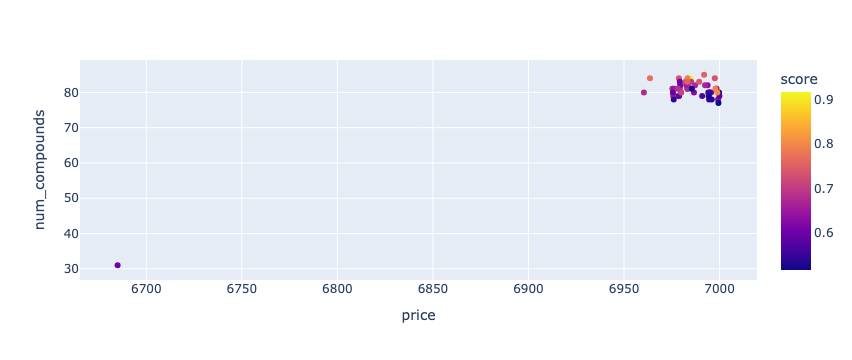

In [30]:
scorer.plot(["price", "num_compounds"])

We can see that our `chem_recipe` is much worse than all our randomly generated selections.

We can get the best selection, or the top 5 selections like this:

In [32]:
best = scorer.best
display(best)

top5 = scorer.top(5)
display(top5)

Recipe_1LJL7WX({Ingredient × 84})

[Recipe_1LJL7WX({Ingredient × 84}),
 Recipe_1LJL8DU({Ingredient × 80}),
 Recipe_1LJL8DZ({Ingredient × 81}),
 Recipe_1LJL8LT({Ingredient × 82}),
 Recipe_1LJL88W({Ingredient × 81})]